## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

# Sections
## EDA
### 1. Load Packages
### 2. Load Data
### 3. Explore Data
### 4. Parse and Inspect Data
### 5. Correlation Mapping
### 6. Baseline
### 7. Build Stategy
### 8. Test 1
## Model Building
### 1. Model Preparation
### 2. Model Testing
####   1. Logistic Regression
####   2. Random Forest Classification
####   3. Gradient Boosting Classification
####   4. Balanced Random Forest Classification
### 3. Pipeline Build
### 4. Pipeline Testing
### 5. Test 2
## Further Exploration

---

## Load packages

### standard packages

In [149]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### ML packages

In [150]:
import scipy as sp
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

### Misc. Packages

In [151]:
# imbalance
# from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import SVMSMOTE


In [414]:
from xgboost import XGBClassifier, plot_importance

## Load Data

In [585]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [586]:
test_data = pd.read_csv('./Test.csv')

## Explore Data

In [228]:
test_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000,41650.000000
mean,63339.155774,0.011525,1.493469,29.986774,-0.000387,1.680792,2.319256,2.505642,1.704010
std,36441.521173,0.106734,0.864138,4.981025,0.999026,0.466175,0.845162,1.119879,0.456492
min,2.000000,0.000000,0.000000,9.202546,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31688.500000,0.000000,1.000000,26.606134,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,63601.000000,0.000000,1.000000,29.979507,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,95017.250000,0.000000,2.000000,33.369989,0.826206,2.000000,3.000000,4.000000,2.000000
max,126178.000000,1.000000,3.000000,55.107509,1.691984,2.000000,4.000000,4.000000,2.000000


In [229]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


## Parse and Inspect Data

In [156]:
features = train_data.columns[3:]

In [157]:
# replace string with numerical -> object to numerical (binary)
train_data.Promotion = train_data.Promotion.replace(['Yes', 'No'], [1,0])

In [158]:
# replace string with numerical -> object to numerical (binary)
test_data.Promotion = test_data.Promotion.replace(['Yes', 'No'], [1,0])

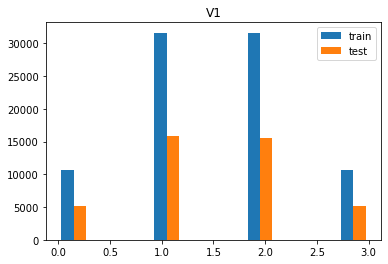

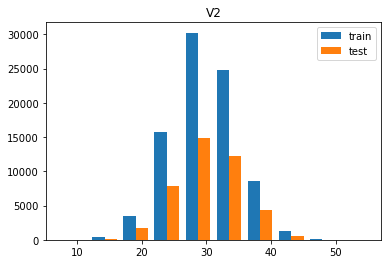

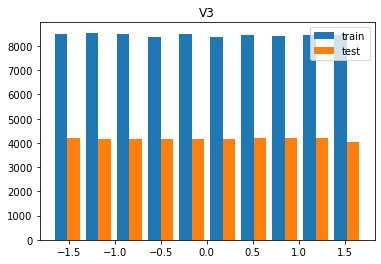

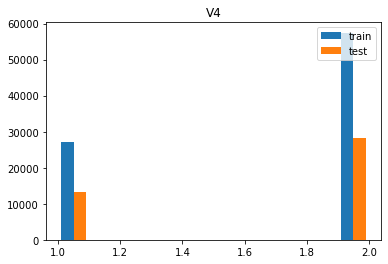

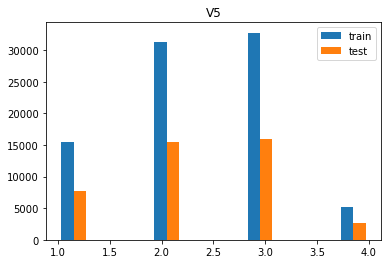

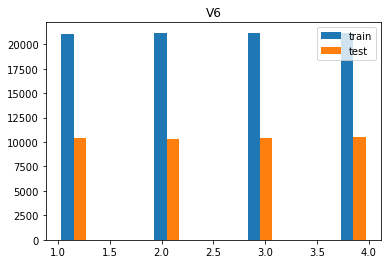

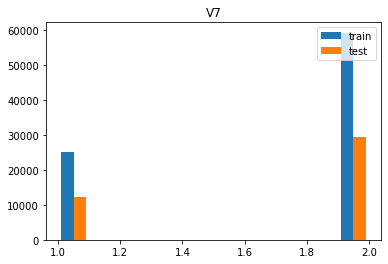

In [159]:
# plot the features histogram to view distribution
for f in features:
    plt.hist([train_data[f], test_data[f]], label=['train', 'test'])
    plt.title(f)
    plt.legend(loc='upper right')
    plt.show()

In [160]:
# isolate promotion rows
promo_train_data = train_data.loc[train_data['Promotion']==1]

In [161]:
# isolate promotion rows -> no promotion
no_promo_data = train_data.loc[train_data.Promotion==0]

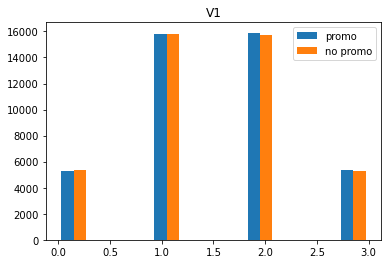

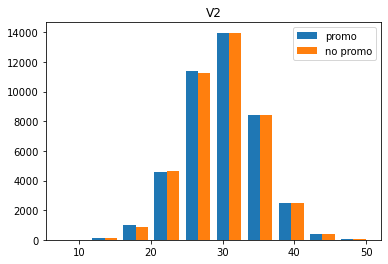

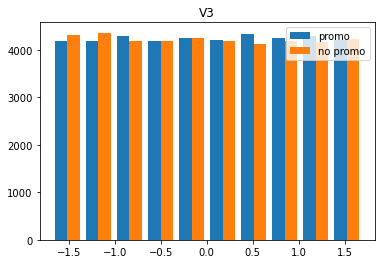

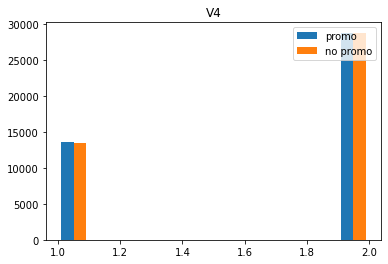

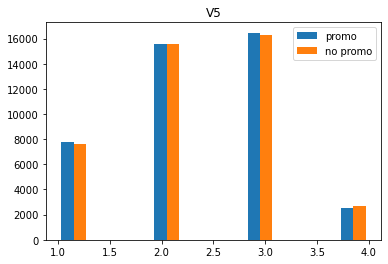

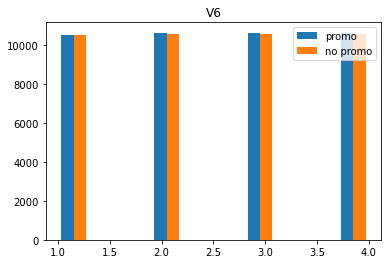

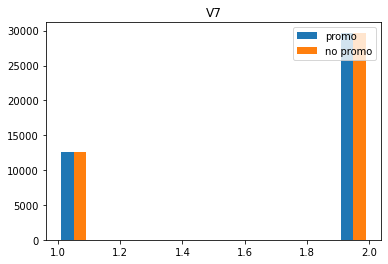

In [162]:
for f in features:
    plt.hist([promo_train_data[f], no_promo_data[f]], label=['promo', 'no promo'])
    plt.title(f)
    plt.legend(loc='upper right')
    plt.show()

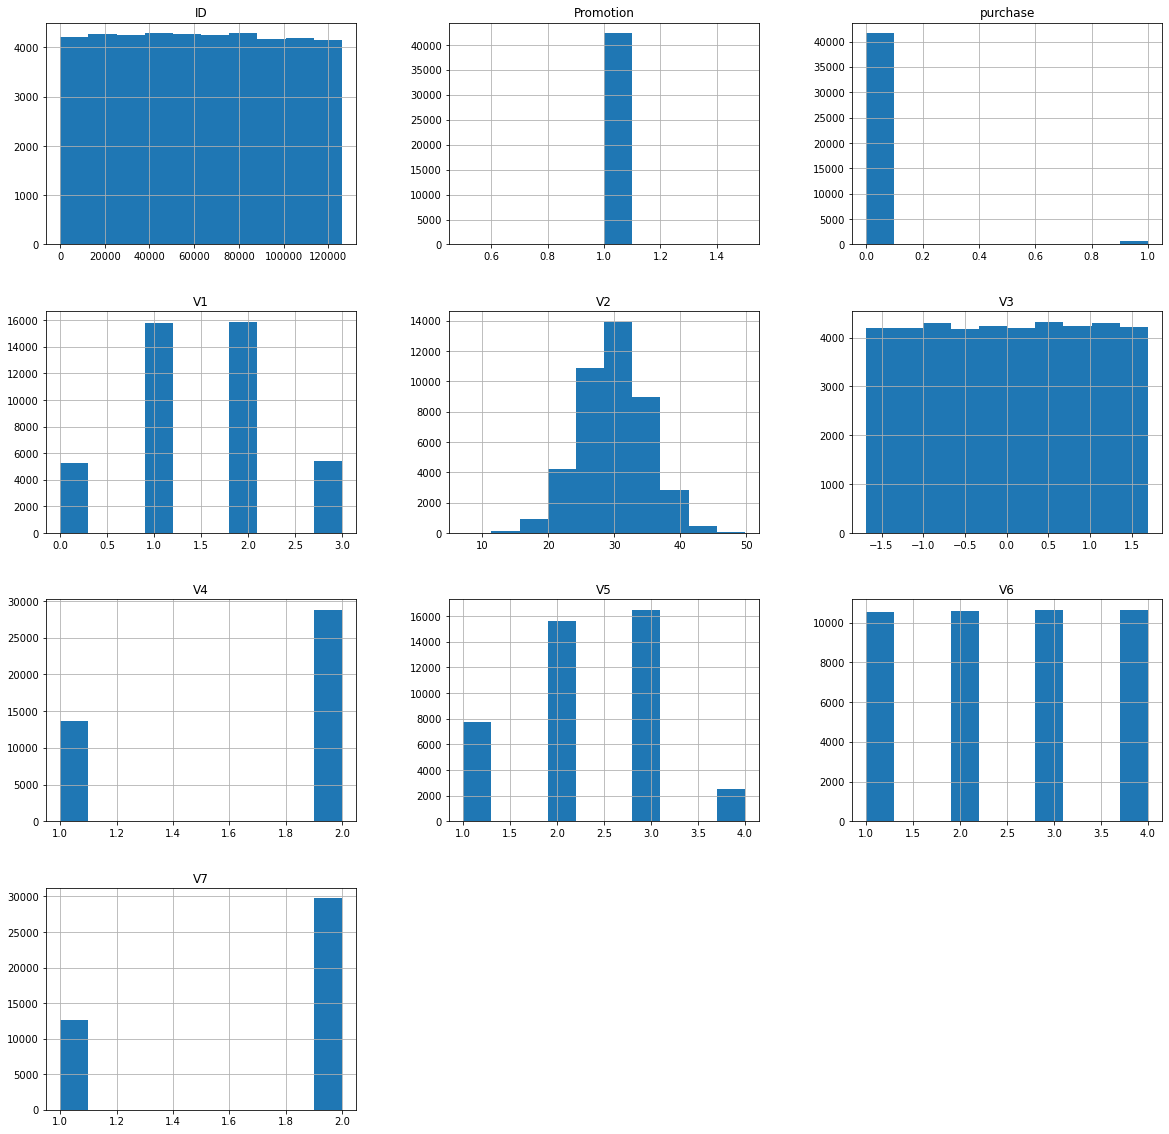

In [163]:
# check distribution of promotion rows
promo_train_data.hist(figsize=(20,20));

In [164]:
# isolate promotions that had purchases
promo_purch_df = promo_train_data.loc[promo_train_data['purchase']==1]

In [165]:
# isolate no promotion that still had purchases 
# this may help see what categories "commonly" purchase, regard of purchase
no_promo_purch = no_promo_data.loc[no_promo_data['purchase']==1]

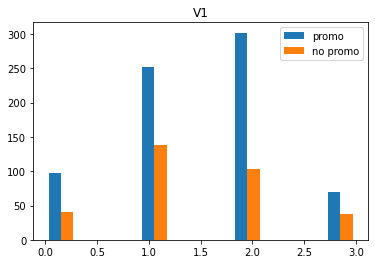

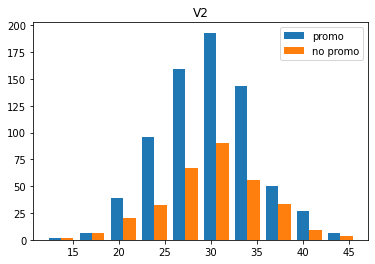

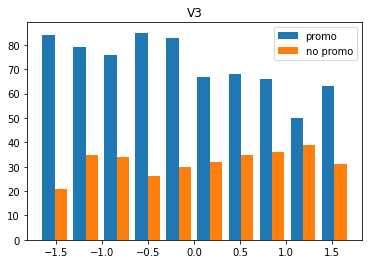

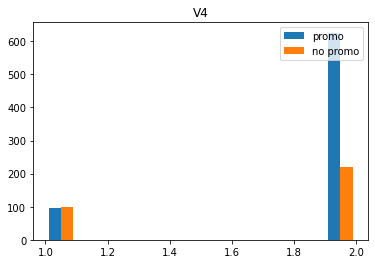

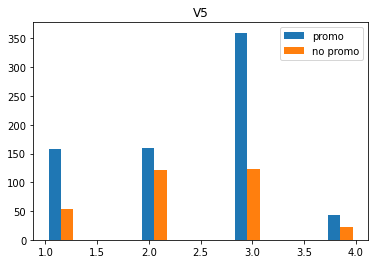

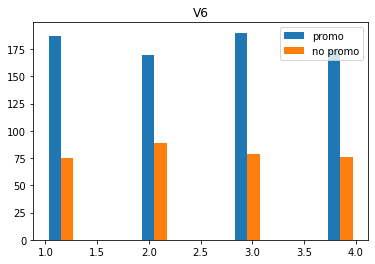

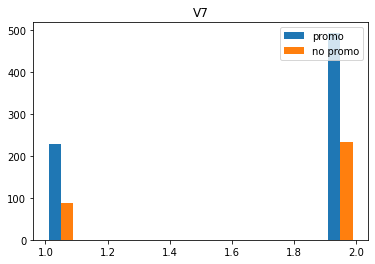

In [166]:
for f in features:
    plt.hist([promo_purch_df[f], no_promo_purch[f]], label=['promo', 'no promo'])
    plt.title(f)
    plt.legend(loc='upper right')
    plt.show()

## Correlation mapping

In [167]:
promo_purch_corr = promo_purch_df.corr()

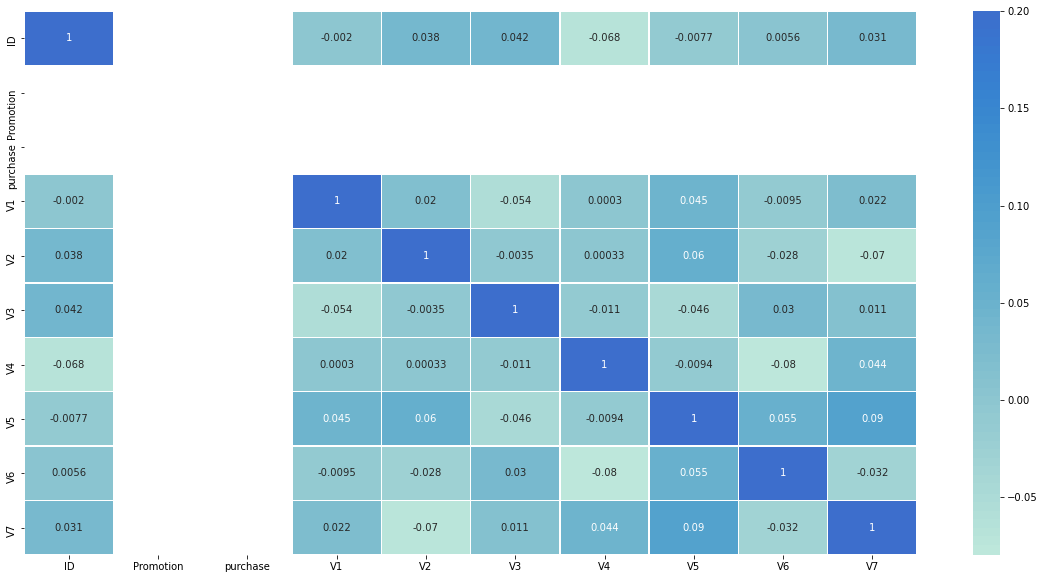

In [168]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(promo_purch_corr, center=.5, annot=True, vmax=.2, linewidths=.5, ax=ax);

In [169]:
no_promo_purch_corr = no_promo_purch.corr()

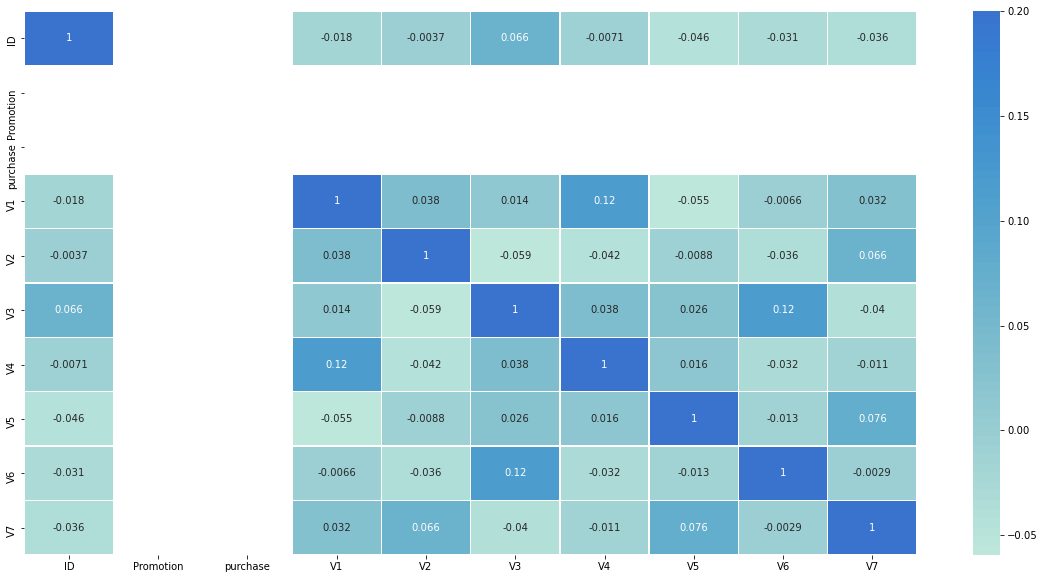

In [170]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(no_promo_purch_corr, center=.5, annot=True, vmax=.2, linewidths=.5, ax=ax);

In [171]:
promo_corr = promo_train_data.corr()

<AxesSubplot:>

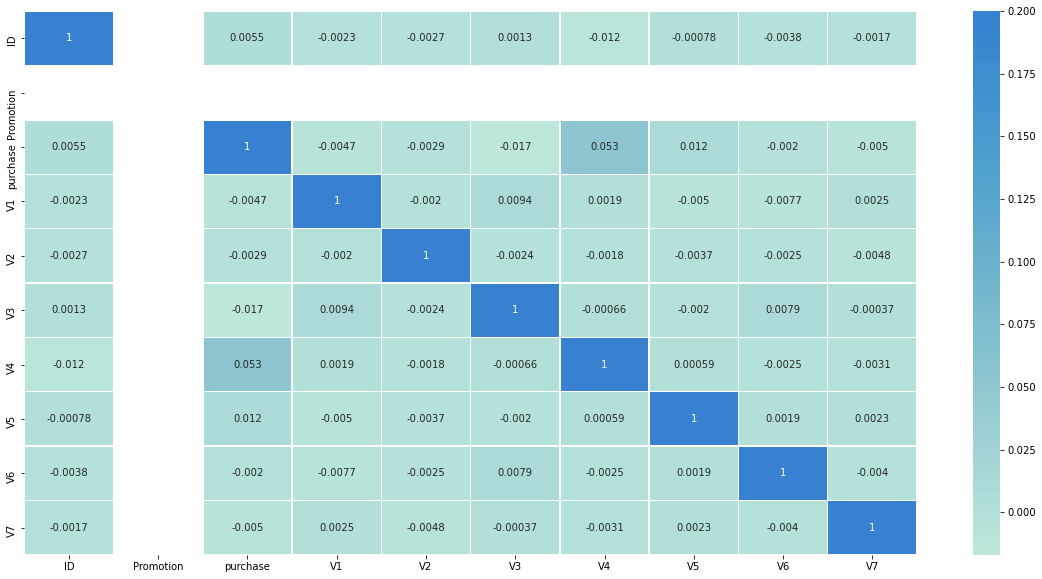

In [172]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(promo_corr, center=.5, annot=True, vmax=.2, linewidths=.5, ax=ax)

## Baseline for IRR and NIR

In [173]:
purch_trt = promo_train_data.purchase.value_counts()[1]
cust_trt = promo_train_data.purchase.count()

In [174]:
purch_ctr = no_promo_data.purchase.value_counts()[1]
cust_ctr = no_promo_data.purchase.count()

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [175]:
irr = (purch_trt / cust_trt) - (purch_ctr / cust_ctr)

In [176]:
irr

0.009454547819772702

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [177]:
nir = (10 * purch_trt - .15 * cust_trt) - 10 * purch_ctr

In [178]:
nir

-2334.5999999999995

## Build strategy

In [179]:
# V1 >=1 & <=2
# V2 >=25 & <=35
# V4 > 1
# V5 >=2 & <=3
# V7 > 1
v1 = (train_data['V1']>=1) & (train_data['V1']<=2)
v2 = (train_data['V2']>=25) & (train_data['V2']<=35)
v3 = (train_data['V3']>=-1.5) & (train_data['V3']<=1.5)
v4 = (train_data['V4']>1)
v5 = (train_data['V5']>=2) & (train_data['V5']<=4)
v6 = (train_data['V6']>=1) & (train_data['V6']<=4)
v7 = (train_data['V7']>1)
tdf = pd.concat([v1, v2, v3, v4, v5, v6, v7], axis=1)
tdf

,V1,V2,V3,V4,V5,V6,V7
0,True,True,True,False,False,True,True
1,False,True,True,True,True,True,True
2,True,True,True,False,False,True,True
3,False,True,True,True,False,True,True
4,False,True,True,False,False,True,True
...,...,...,...,...,...,...,...
84529,True,True,True,False,False,True,False
84530,False,True,True,False,False,True,False
84531,True,True,True,True,True,True,True
84532,True,False,True,True,True,True,True


In [180]:
strategy = ((train_data['V1']>=1) & (train_data['V1']<=2)
& (train_data['V2']>=29) & (train_data['V2']<=31)
& (train_data['V3']>=-1.5) & (train_data['V3']<=1.5)
& (train_data['V4']>1)
& (train_data['V5']>=2) & (train_data['V5']<=4)
& (train_data['V6']>=1) & (train_data['V6']<=4)
& (train_data['V7']>1))

In [181]:
strategy = strategy.replace([True, False], ['Yes', 'No'])

In [182]:
len(strategy)

84534

In [183]:
tdf = tdf.replace([True, False], ['Yes', 'No'])

## Test 1

In [184]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promo = []
    strategy = ((df['V1']>=1) & (df['V1']<=2)
& (df['V2']>=27) & (df['V2']<=33)
& (df['V3']>=0) & (df['V3']<=1)
& (df['V4']>1)
& (df['V5']>=3) & (df['V5']<=3.5)
& (df['V6']>=2) & (df['V6']<=3)
& (df['V7']>1))
    
    strategy = strategy.replace([True, False], ['Yes', 'No'])
    
    promotion = np.array(strategy)
    
    return promotion

In [185]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0203.

Your nir with this strategy is 10.45.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.02030456852791878, 10.450000000000003)

---

# Model Building Section




## Model preparation




### Original Attempt

In [186]:
# Get dummies (if necessary for binary classification)
dummy_df = pd.get_dummies(train_data, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
dummy_df.columns

Index(['ID', 'Promotion', 'purchase', 'V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
       'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2', 'V5_3', 'V5_4', 'V6_1', 'V6_2',
       'V6_3', 'V6_4', 'V7_1', 'V7_2'],
      dtype='object')

In [222]:
# generate X, y from Categories and 'purchase'
X = train_data.iloc[:,3:]
y = train_data['purchase']

In [188]:
# call SVMSMOTE to resample data to help with imbalance
svms = SVMSMOTE(random_state=42)

X, y = svms.fit_resample(X,y)

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [232]:
print(X_train)
print(X_test)
print(y_train.value_counts())
print(y_test.value_counts())

       V1         V2        V3  V4  V5  V6  V7
66588   3  34.470493 -1.078506   1   1   1   2
62125   1  28.065819 -1.165083   1   1   3   1
27827   1  27.142590 -1.511395   1   3   3   2
66648   3  28.782344 -1.078506   1   1   1   2
47392   2  39.605508 -0.645617   2   3   1   2
...    ..        ...       ...  ..  ..  ..  ..
6265    1  25.513060 -0.126150   1   2   3   2
54886   3  31.485170  0.047006   1   2   2   2
76820   1  28.643406  0.653050   2   1   1   2
860     2  21.724511  1.085939   1   3   3   2
15795   3  25.638208 -1.424817   2   1   2   1

[67627 rows x 7 columns]
       V1         V2        V3  V4  V5  V6  V7
6264    3  18.012754 -1.511395   2   2   4   1
41822   2  28.676557 -0.126150   2   3   3   2
8569    0  28.817748 -1.511395   2   4   3   2
41228   1  26.140783 -0.905350   2   1   4   2
24896   1  32.346423  0.566472   1   2   3   1
...    ..        ...       ...  ..  ..  ..  ..
31179   3  26.310883 -0.299306   1   3   1   1
17641   2  24.402187 -1.078506   2

In [190]:
# prepare scaler to scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Secondary Attempt

In [587]:
# generate X, y from Categories and 'purchase'
X_train = train_data.iloc[:,3:]
y_train = train_data['purchase']
X_test = test_data.iloc[:,3:]
y_test = test_data['purchase']

In [534]:
print(X_train)
print(X_test)
print(y_train.value_counts())
print(y_test.value_counts())

       V1         V2        V3  V4  V5  V6  V7
0       2  30.443518 -1.165083   1   1   3   2
1       3  32.159350 -0.645617   2   3   2   2
2       2  30.431659  0.133583   1   1   4   2
3       0  26.588914 -0.212728   2   1   4   2
4       3  28.044332 -0.385883   1   1   2   2
...    ..        ...       ...  ..  ..  ..  ..
84529   1  30.084876  1.345672   1   1   3   1
84530   3  33.501485 -0.299306   1   1   4   1
84531   1  31.492019  1.085939   2   3   2   2
84532   1  37.766106  0.999361   2   2   1   2
84533   1  21.720835  1.085939   2   2   1   2

[84534 rows x 7 columns]
       V1         V2        V3  V4  V5  V6  V7
0       1  41.376390  1.172517   1   1   2   2
1       1  25.163598  0.653050   2   2   2   2
2       1  26.553778 -1.597972   2   3   4   2
3       2  28.529691 -1.078506   2   3   2   2
4       2  32.378538  0.479895   2   2   1   2
...    ..        ...       ...  ..  ..  ..  ..
41645   1  33.073275 -0.126150   2   2   2   2
41646   0  32.065720  0.999361   2

C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='purchase', ylabel='count'>

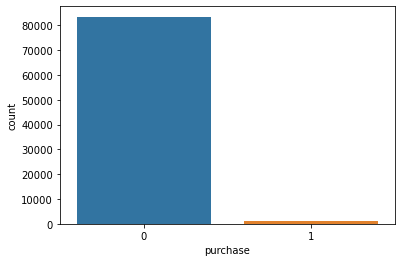

In [588]:
sns.countplot(train_data['purchase'])

In [420]:
# call SVMSMOTE to resample data to help with imbalance
svms = SVMSMOTE(random_state=42)

X_train, y_train = svms.fit_resample(X_train,y_train)

C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='purchase', ylabel='count'>

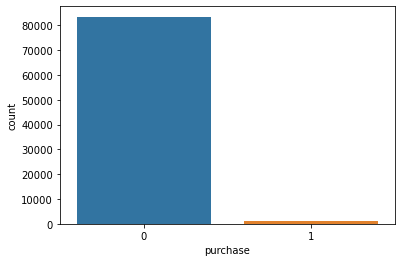

In [401]:
sns.countplot(y_train)

### Combining undersampling and oversampling

#### Manual undersampling

In [633]:
class_0, class_1 = train_data.purchase.value_counts()

In [634]:
train_class_0 = train_data[train_data['purchase']==0]
train_class_1 = train_data[train_data['purchase']==1]

In [641]:
train_class_0_undersample = train_class_0.sample(class_1)

In [642]:
train_undersample = pd.concat([train_class_0_undersample, train_class_1], axis=0)

In [645]:
train_undersample.purchase.value_counts()

1    1040
0    1040
Name: purchase, dtype: int64

In [646]:
X_train_undersample = train_undersample.iloc[:,3:]
y_train_undersample = train_undersample['purchase']
X_test = test_data.iloc[:,3:]
y_test = test_data['purchase']

#### SMOTETomek combined undersampling & oversampling


In [589]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek()
X_smt, y_smt = smt.fit_sample(X_train,y_train)

C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



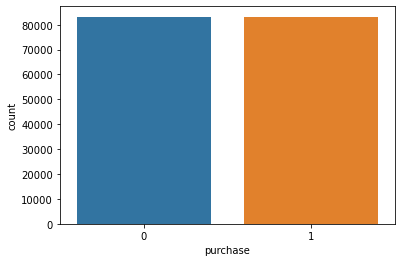

In [680]:
sns.countplot(y_smt);

C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



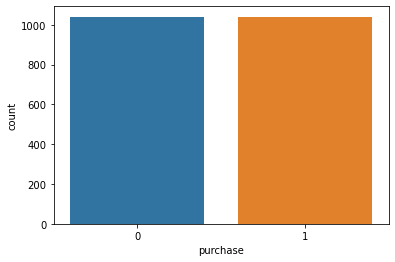

In [681]:
sns.countplot(y_train_undersample);

In [594]:
# prepare scaler to scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [595]:
# prepare scaler to scale data for SMOTE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_smt)
X_smt_scaled = scaler.transform(X_smt)
X_test_scaled = scaler.transform(X_test)

In [659]:
# prepare scaler to scale data for Undersampling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train_undersample)
X_train_undersample_scaled = scaler.transform(X_train_undersample)
X_test_scaled = scaler.transform(X_test)

## Model Testing

In [686]:
def test_models_scores(classifer, X_tr, y_tr, X_te, y_te):
    
    print('****************************************************************')
    print(f'Fitting Model: {classifer}')
    classifier = classifer.fit(X_tr, y_tr)
    print('Predicting values')
    classifer_y_pred = classifer.predict(X_te)
    print('****************************************************************')
    print("Computing confusion matrix")
    print(confusion_matrix(y_te, classifer_y_pred))
    plot = plot_confusion_matrix(classifer, X_te, y_te)
    plot
    
    promotion_yes_no = []
    for value in classifer_y_pred:
        if value == 0:
            promotion_yes_no.append("No")
        if value == 1:
            promotion_yes_no.append("Yes")
            
    promotion = np.asarray(promotion_yes_no)
    print('****************************************************************')
    print(f'accuracy_score: {accuracy_score(y_te, classifer_y_pred) * 100}%')
    print(f'f1_score: {f1_score(y_te, classifer_y_pred) * 100}%')
    print(f'recall_score: {recall_score(y_te, classifer_y_pred) * 100}%')
    print(f'precision_score: {precision_score(y_te, classifer_y_pred) * 100}%')
    print('****************************************************************')
    return promotion

### Logistic Regression

****************************************************************
Fitting Model: LogisticRegression()
Predicting values
****************************************************************
Computing confusion matrix
[[41170     0]
 [  480     0]]
****************************************************************
accuracy_score: 98.84753901560624%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

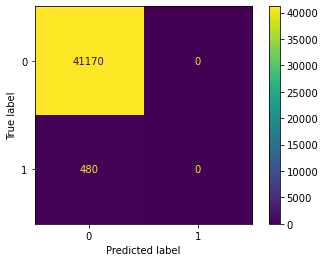

In [655]:
# logistic regression
lr = LogisticRegression()
test_models_scores(lr, X_train, y_train, X_test, y_test)

****************************************************************
Fitting Model: LogisticRegression()
Predicting values
****************************************************************
Computing confusion matrix
[[41170     0]
 [  480     0]]
****************************************************************
accuracy_score: 98.84753901560624%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

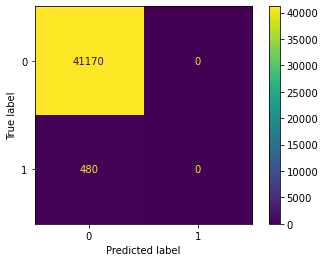

In [650]:
test_models_scores(lr, X_train_scaled, y_train, X_test_scaled, y_test)

### Smotetomek sampling

****************************************************************
Fitting Model: LogisticRegression()
Predicting values
****************************************************************
Computing confusion matrix
[[23116 18054]
 [  218   262]]
****************************************************************
accuracy_score: 56.1296518607443%
f1_score: 2.787827197276016%
recall_score: 54.58333333333333%
precision_score: 1.4304433282376066%
****************************************************************


array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

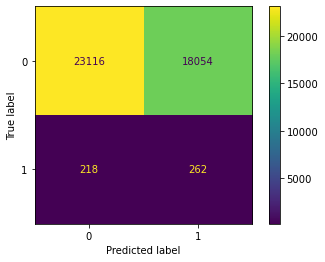

In [656]:
# logistic regression
test_models_scores(lr, X_smt, y_smt, X_test, y_test)

****************************************************************
Fitting Model: LogisticRegression()
Predicting values
****************************************************************
Computing confusion matrix
[[23114 18056]
 [  218   262]]
****************************************************************
accuracy_score: 56.124849939975995%
f1_score: 2.787530588360464%
recall_score: 54.58333333333333%
precision_score: 1.4302871492521017%
****************************************************************


array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

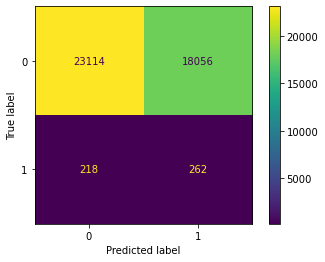

In [657]:
# logistic regression
test_models_scores(lr, X_smt_scaled, y_smt, X_test_scaled, y_test)

#### Manual Undersampled data

****************************************************************
Fitting Model: LogisticRegression()
Predicting values
****************************************************************
Computing confusion matrix
[[16255 24915]
 [  126   354]]
****************************************************************
accuracy_score: 39.87755102040816%
f1_score: 2.749621344518234%
recall_score: 73.75%
precision_score: 1.4009260358542088%
****************************************************************


array(['No', 'Yes', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

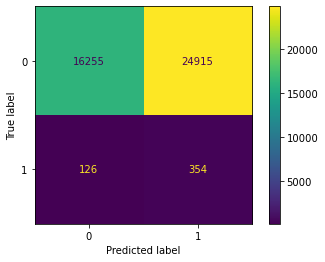

In [658]:
test_models_scores(lr, X_train_undersample, y_train_undersample, X_test, y_test)

****************************************************************
Fitting Model: LogisticRegression()
Predicting values
****************************************************************
Computing confusion matrix
[[16203 24967]
 [  125   355]]
****************************************************************
accuracy_score: 39.755102040816325%
f1_score: 2.751724672506007%
recall_score: 73.95833333333334%
precision_score: 1.401942974488587%
****************************************************************


array(['No', 'Yes', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

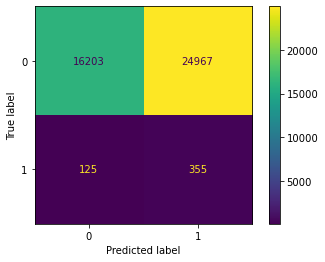

In [661]:
test_models_scores(lr, X_train_undersample_scaled, y_train_undersample, X_test_scaled, y_test)

### Random Forest Classifier

****************************************************************
Fitting Model: RandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41140    30]
 [  480     0]]
****************************************************************
accuracy_score: 98.77551020408163%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

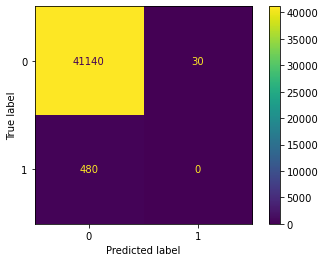

In [599]:
rand_mod = RandomForestClassifier()
test_models_scores(rand_mod, X_train, y_train, X_test, y_test)

****************************************************************
Fitting Model: RandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41138    32]
 [  479     1]]
****************************************************************
accuracy_score: 98.77310924369748%
f1_score: 0.3898635477582846%
recall_score: 0.20833333333333334%
precision_score: 3.0303030303030303%
****************************************************************


array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

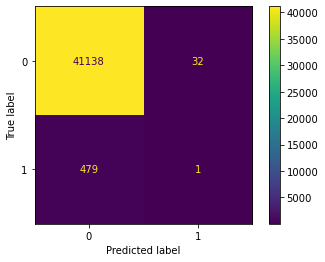

In [600]:
test_models_scores(rand_mod, X_train_scaled, y_train, X_test_scaled, y_test)

### Smotetomek sampling

****************************************************************
Fitting Model: RandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41170     0]
 [  480     0]]
****************************************************************
accuracy_score: 98.84753901560624%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

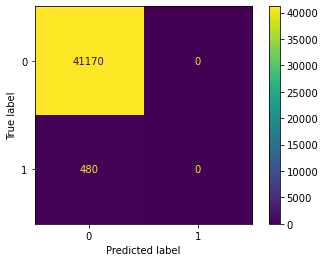

In [572]:
rand_mod = RandomForestClassifier()
test_models_scores(rand_mod, X_smt, y_smt, X_test, y_test)

****************************************************************
Fitting Model: RandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[39008  2162]
 [  453    27]]
****************************************************************
accuracy_score: 93.72148859543817%
f1_score: 2.0232296740352185%
recall_score: 5.625%
precision_score: 1.2334399269072636%
****************************************************************


array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

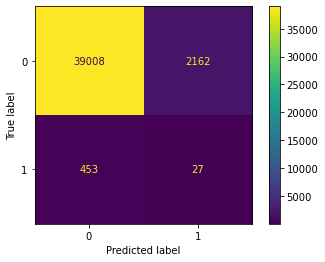

In [602]:
test_models_scores(rand_mod, X_smt_scaled, y_smt, X_test_scaled, y_test)

#### Manual Undersampled data

****************************************************************
Fitting Model: RandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[22944 18226]
 [  212   268]]
****************************************************************
accuracy_score: 55.73109243697479%
f1_score: 2.82491830926531%
recall_score: 55.833333333333336%
precision_score: 1.4491186330701848%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

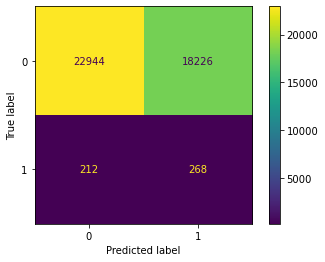

In [662]:
test_models_scores(rand_mod, X_train_undersample, y_train_undersample, X_test, y_test)

****************************************************************
Fitting Model: RandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[22770 18400]
 [  218   262]]
****************************************************************
accuracy_score: 55.298919567827134%
f1_score: 2.737436004597221%
recall_score: 54.58333333333333%
precision_score: 1.403922409173722%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

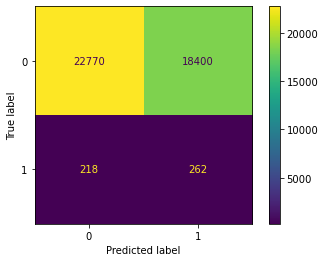

In [663]:
test_models_scores(rand_mod, X_train_undersample_scaled, y_train_undersample, X_test_scaled, y_test)

### Gradient Boosting Classifier

****************************************************************
Fitting Model: GradientBoostingClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41134    36]
 [  479     1]]
****************************************************************
accuracy_score: 98.76350540216087%
f1_score: 0.3868471953578337%
recall_score: 0.20833333333333334%
precision_score: 2.7027027027027026%
****************************************************************


array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

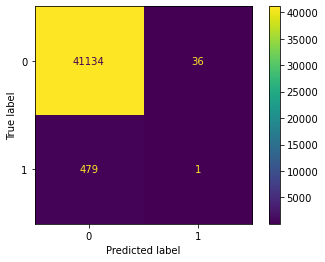

In [603]:
gbc = GradientBoostingClassifier()
test_models_scores(gbc, X_train, y_train, X_test, y_test)

****************************************************************
Fitting Model: GradientBoostingClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41130    40]
 [  480     0]]
****************************************************************
accuracy_score: 98.75150060024009%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

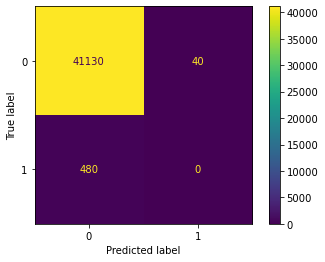

In [604]:
test_models_scores(gbc, X_train_scaled, y_train, X_test_scaled, y_test)

### Smotetomek sampling

****************************************************************
Fitting Model: GradientBoostingClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[   15 41155]
 [    0   480]]
****************************************************************
accuracy_score: 1.1884753901560625%
f1_score: 2.2794728718983737%
recall_score: 100.0%
precision_score: 1.1528761859012848%
****************************************************************


array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype='<U3')

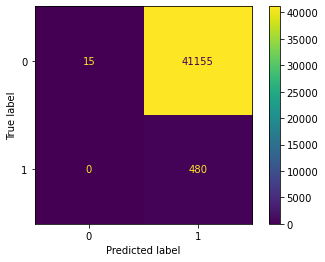

In [574]:
gbc = GradientBoostingClassifier()
test_models_scores(gbc, X_smt, y_smt, X_test, y_test)

****************************************************************
Fitting Model: GradientBoostingClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[31306  9864]
 [  337   143]]
****************************************************************
accuracy_score: 75.5078031212485%
f1_score: 2.727186039858873%
recall_score: 29.791666666666668%
precision_score: 1.4289997002098531%
****************************************************************


array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

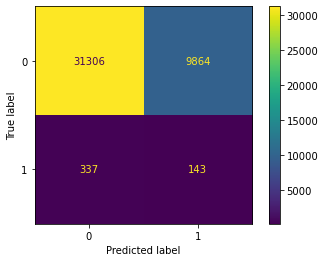

In [605]:
test_models_scores(gbc, X_smt_scaled, y_smt, X_test_scaled, y_test)

#### Manual Undersampled data

****************************************************************
Fitting Model: GradientBoostingClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[22600 18570]
 [  193   287]]
****************************************************************
accuracy_score: 54.95078031212485%
f1_score: 2.9684025443450377%
recall_score: 59.791666666666664%
precision_score: 1.5219812271305084%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

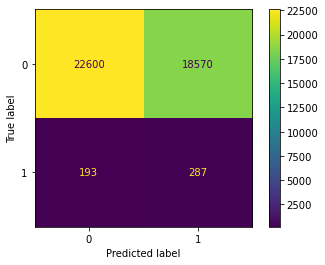

In [664]:
test_models_scores(gbc, X_train_undersample, y_train_undersample, X_test, y_test)

****************************************************************
Fitting Model: GradientBoostingClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[22597 18573]
 [  193   287]]
****************************************************************
accuracy_score: 54.94357743097239%
f1_score: 2.9679420889348505%
recall_score: 59.791666666666664%
precision_score: 1.5217391304347827%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

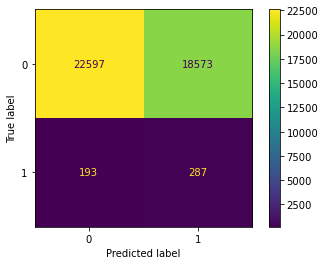

In [665]:
test_models_scores(gbc, X_train_undersample_scaled, y_train_undersample, X_test_scaled, y_test)

### ADA Boosting Classifier

****************************************************************
Fitting Model: AdaBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41170     0]
 [  480     0]]
****************************************************************
accuracy_score: 98.84753901560624%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

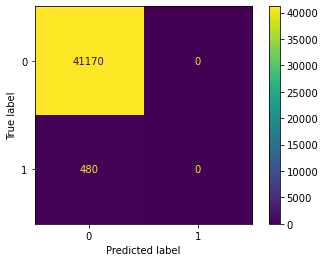

In [575]:
adaclf = AdaBoostClassifier()
test_models_scores(adaclf, X_train, y_train, X_test, y_test)

****************************************************************
Fitting Model: AdaBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41170     0]
 [  480     0]]
****************************************************************
accuracy_score: 98.84753901560624%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

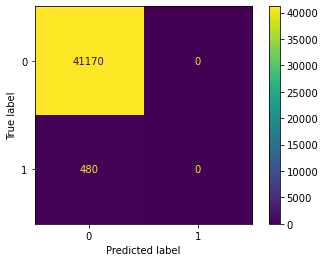

In [606]:
test_models_scores(adaclf, X_train_scaled, y_train, X_test_scaled, y_test)

### Smotetomek sampling

****************************************************************
Fitting Model: AdaBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[ 1160 40010]
 [   12   468]]
****************************************************************
accuracy_score: 3.908763505402161%
f1_score: 2.285267835343523%
recall_score: 97.5%
precision_score: 1.1561836059093828%
****************************************************************


array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype='<U3')

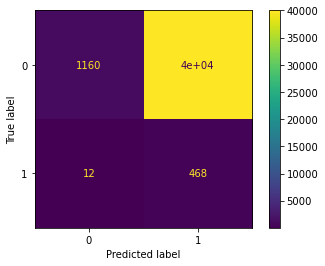

In [576]:
ada_smt = AdaBoostClassifier()
test_models_scores(ada_smt, X_smt, y_smt, X_test, y_test)

****************************************************************
Fitting Model: AdaBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[23640 17530]
 [  237   243]]
****************************************************************
accuracy_score: 57.342136854741895%
f1_score: 2.6625760149016604%
recall_score: 50.625%
precision_score: 1.367242446407472%
****************************************************************


array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

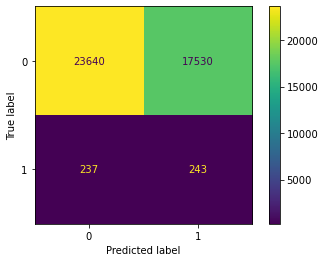

In [607]:
test_models_scores(ada_smt, X_smt_scaled, y_smt, X_test_scaled, y_test)

#### Manual Undersampled data

****************************************************************
Fitting Model: AdaBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[21536 19634]
 [  179   301]]
****************************************************************
accuracy_score: 52.4297719087635%
f1_score: 2.9488121479304437%
recall_score: 62.708333333333336%
precision_score: 1.509907198394783%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

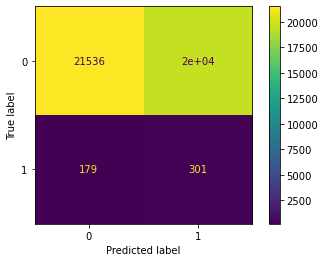

In [666]:
test_models_scores(adaclf, X_train_undersample, y_train_undersample, X_test, y_test)

****************************************************************
Fitting Model: AdaBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[21536 19634]
 [  179   301]]
****************************************************************
accuracy_score: 52.4297719087635%
f1_score: 2.9488121479304437%
recall_score: 62.708333333333336%
precision_score: 1.509907198394783%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

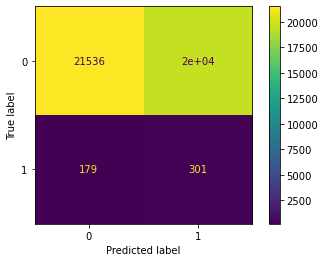

In [667]:
test_models_scores(adaclf, X_train_undersample_scaled, y_train_undersample, X_test_scaled, y_test)

### RUS  Boosting Classifier

****************************************************************
Fitting Model: RUSBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41170     0]
 [  480     0]]
****************************************************************
accuracy_score: 98.84753901560624%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

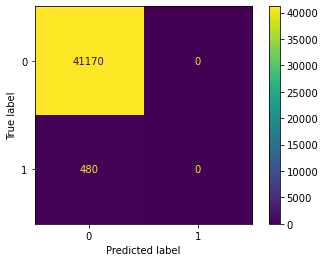

In [577]:
from imblearn.ensemble import RUSBoostClassifier
rus = RUSBoostClassifier()
test_models_scores(rus, X_train, y_train, X_test, y_test)

****************************************************************
Fitting Model: RUSBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[23896 17274]
 [  201   279]]
****************************************************************
accuracy_score: 58.04321728691476%
f1_score: 3.0943270670437526%
recall_score: 58.12500000000001%
precision_score: 1.589471885147838%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

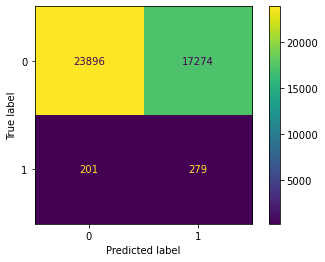

In [608]:
test_models_scores(rus, X_train_scaled, y_train, X_test_scaled, y_test)

### Smotetomek sampling

****************************************************************
Fitting Model: RUSBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[ 1160 40010]
 [   12   468]]
****************************************************************
accuracy_score: 3.908763505402161%
f1_score: 2.285267835343523%
recall_score: 97.5%
precision_score: 1.1561836059093828%
****************************************************************


array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype='<U3')

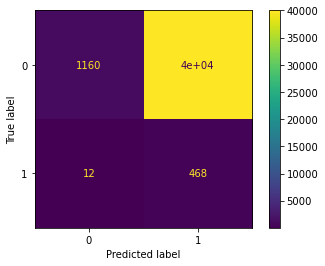

In [578]:
rus = RUSBoostClassifier()
test_models_scores(rus, X_smt, y_smt, X_test, y_test)

****************************************************************
Fitting Model: RUSBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[23640 17530]
 [  237   243]]
****************************************************************
accuracy_score: 57.342136854741895%
f1_score: 2.6625760149016604%
recall_score: 50.625%
precision_score: 1.367242446407472%
****************************************************************


array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

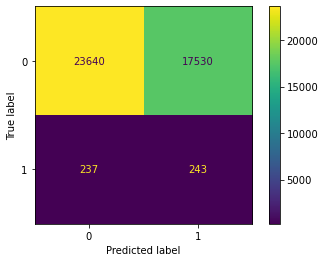

In [609]:
test_models_scores(rus, X_smt_scaled, y_smt, X_test_scaled, y_test)

#### Manual Undersampled data

****************************************************************
Fitting Model: RUSBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[21536 19634]
 [  179   301]]
****************************************************************
accuracy_score: 52.4297719087635%
f1_score: 2.9488121479304437%
recall_score: 62.708333333333336%
precision_score: 1.509907198394783%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

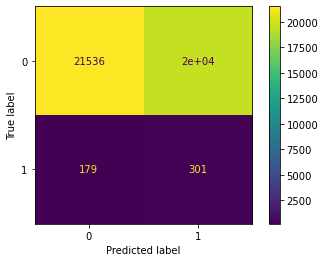

In [668]:
test_models_scores(rus, X_train_undersample, y_train_undersample, X_test, y_test)

****************************************************************
Fitting Model: RUSBoostClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[21536 19634]
 [  179   301]]
****************************************************************
accuracy_score: 52.4297719087635%
f1_score: 2.9488121479304437%
recall_score: 62.708333333333336%
precision_score: 1.509907198394783%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

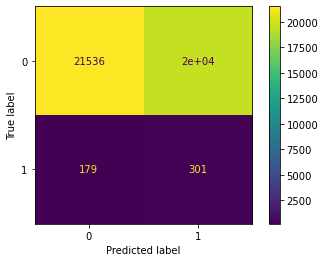

In [669]:
test_models_scores(rus, X_train_undersample_scaled, y_train_undersample, X_test_scaled, y_test)

### Balanced Random Forest Classifier

****************************************************************
Fitting Model: BalancedRandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41170     0]
 [  480     0]]
****************************************************************
accuracy_score: 98.84753901560624%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

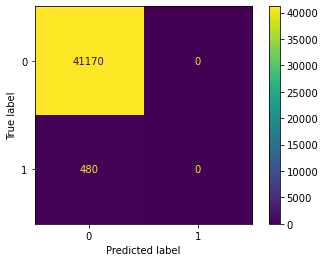

In [579]:
from imblearn.ensemble import BalancedRandomForestClassifier  

blrf = BalancedRandomForestClassifier()
test_models_scores(blrf, X_train, y_train, X_test, y_test)

****************************************************************
Fitting Model: BalancedRandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[23512 17658]
 [  212   268]]
****************************************************************
accuracy_score: 57.09483793517407%
f1_score: 2.9120938824296427%
recall_score: 55.833333333333336%
precision_score: 1.495035144482874%
****************************************************************


array(['Yes', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

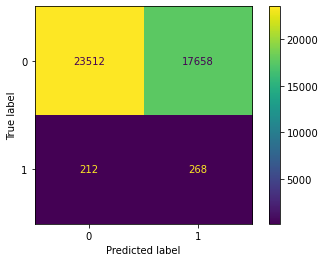

In [610]:
test_models_scores(blrf, X_train_scaled, y_train, X_test_scaled, y_test)

### Smotetomek sampling

****************************************************************
Fitting Model: BalancedRandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[41170     0]
 [  480     0]]
****************************************************************
accuracy_score: 98.84753901560624%
f1_score: 0.0%
recall_score: 0.0%
precision_score: 0.0%
****************************************************************


C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U2')

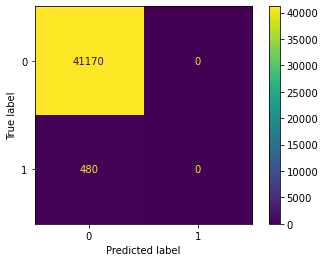

In [580]:
blrf = BalancedRandomForestClassifier()
test_models_scores(blrf, X_smt, y_smt, X_test, y_test)

****************************************************************
Fitting Model: BalancedRandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[39028  2142]
 [  451    29]]
****************************************************************
accuracy_score: 93.77430972388956%
f1_score: 2.1878536401357978%
recall_score: 6.041666666666667%
precision_score: 1.3357899585444497%
****************************************************************


array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

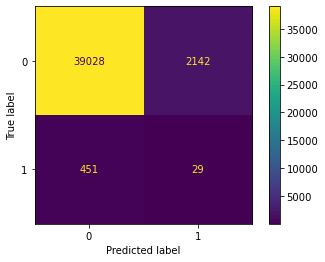

In [611]:
test_models_scores(blrf, X_smt_scaled, y_smt, X_test_scaled, y_test)

#### Manual Undersampled data

****************************************************************
Fitting Model: BalancedRandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[22784 18386]
 [  218   262]]
****************************************************************
accuracy_score: 55.332533013205285%
f1_score: 2.73943956503555%
recall_score: 54.58333333333333%
precision_score: 1.404976404976405%
****************************************************************


array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

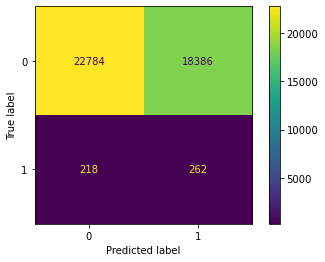

In [670]:
test_models_scores(blrf, X_train_undersample, y_train_undersample, X_test, y_test)

****************************************************************
Fitting Model: BalancedRandomForestClassifier()
Predicting values
****************************************************************
Computing confusion matrix
[[23044 18126]
 [  213   267]]
****************************************************************
accuracy_score: 55.968787515006%
f1_score: 2.829438880941027%
recall_score: 55.625%
precision_score: 1.4516392105692384%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

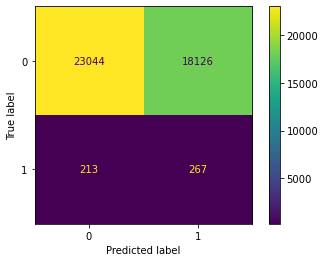

In [671]:
test_models_scores(blrf, X_train_undersample_scaled, y_train_undersample, X_test_scaled, y_test)

### XGB Classifier

****************************************************************
Fitting Model: XGBClassifier(colsample_bytree=0.8, max_depth=5, n_estimators=1000, nthread=4,
              random_state=42, subsample=0.8)
Predicting values
****************************************************************
Computing confusion matrix
[[   36 41134]
 [    0   480]]
****************************************************************
accuracy_score: 1.2388955582232895%
f1_score: 2.280610063191904%
recall_score: 100.0%
precision_score: 1.1534579708751862%
****************************************************************


array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes'], dtype='<U3')

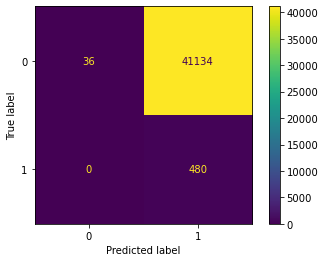

In [678]:
xgb = XGBClassifier(random_state=42,
                    learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1)


test_models_scores(xgb, 
                   X_smt_scaled, 
                   y_smt, 
                   X_test_scaled, 
                   y_test)

### Smotetomek sampling

In [543]:
xgb_smt = XGBClassifier(random_state=42,
                    learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1)

xgb_smt.fit(X_smt, y_smt)
xgb_smt_y_pred = xgb_smt.predict(X_test.values)
confusion_matrix(y_test, xgb_smt_y_pred)

array([[ 1468, 39702],
       [   12,   468]], dtype=int64)

In [545]:
print(f'accuracy_score: {accuracy_score(y_test, xgb_smt_y_pred) * 100}%')
print(f'f1_score: {f1_score(y_test, xgb_smt_y_pred) * 100}%')
print(f'recall_score: {recall_score(y_test, xgb_smt_y_pred) * 100}%')
print(f'precision_score: {precision_score(y_test, xgb_smt_y_pred) * 100}%')

accuracy_score: 4.648259303721488%
f1_score: 2.302583025830258%
recall_score: 97.5%
precision_score: 1.1650485436893203%


****************************************************************
Fitting Model: XGBClassifier(colsample_bytree=0.8, max_depth=5, n_estimators=1000, nthread=4,
              random_state=42, subsample=0.8)
Predicting values
****************************************************************
Computing confusion matrix
[[22387 18783]
 [  162   318]]
****************************************************************
accuracy_score: 54.513805522208884%
f1_score: 3.248046575762219%
recall_score: 66.25%
precision_score: 1.6648343018690122%
****************************************************************


Exception ignored in: <function Booster.__del__ at 0x000001D08FE7AA68>
Traceback (most recent call last):
  File "C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


array(['Yes', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

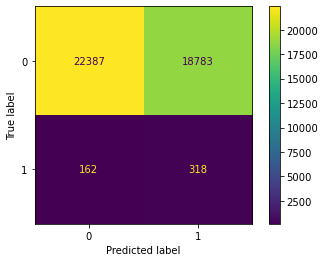

In [676]:
test_models_scores(xgb, X_train_undersample_scaled, y_train_undersample, X_test_scaled, y_test)

## Voting Classifier

In [548]:
from sklearn.ensemble import VotingClassifier

In [620]:
eclf1 = VotingClassifier(estimators=[
    ('lr', lr), 
    ('rus', rus), 
    ('ada', adaclf), 
    ('blrf', blrf)], 
    voting='hard',
    weights=[1,2,1,2])

### regular dataset

****************************************************************
Fitting Model: VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rus', RUSBoostClassifier()),
                             ('ada', AdaBoostClassifier()),
                             ('blrf', BalancedRandomForestClassifier())],
                 weights=[1, 2, 1, 2])
Predicting values
****************************************************************
Computing confusion matrix
[[27689 13481]
 [  252   228]]
****************************************************************
accuracy_score: 67.02761104441777%
f1_score: 3.21375713580943%
recall_score: 47.5%
precision_score: 1.6631410022612882%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

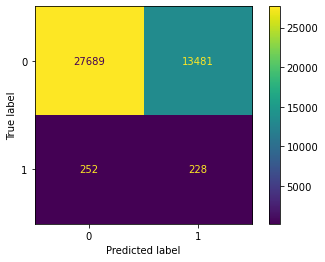

In [621]:
test_models_scores(eclf1, X_train, y_train, X_test, y_test)

### scaled original dataset

****************************************************************
Fitting Model: VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rus', RUSBoostClassifier()),
                             ('ada', AdaBoostClassifier()),
                             ('blrf', BalancedRandomForestClassifier())],
                 weights=[1, 2, 1, 2])
Predicting values
****************************************************************
Computing confusion matrix
[[28257 12913]
 [  264   216]]
****************************************************************
accuracy_score: 68.36254501800721%
f1_score: 3.174369902270556%
recall_score: 45.0%
precision_score: 1.645212887500952%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

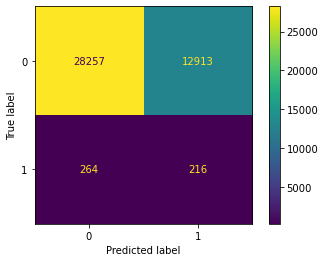

In [627]:
test_models_scores(eclf1, X_train_scaled, y_train, X_test_scaled, y_test)

### SMOTETomek dataset

****************************************************************
Fitting Model: VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rus', RUSBoostClassifier()),
                             ('ada', AdaBoostClassifier()),
                             ('blrf', BalancedRandomForestClassifier())],
                 weights=[1, 2, 1, 2])
Predicting values
****************************************************************
Computing confusion matrix
[[28767 12403]
 [  302   178]]
****************************************************************
accuracy_score: 69.49579831932773%
f1_score: 2.725671847484879%
recall_score: 37.083333333333336%
precision_score: 1.4148318893569667%
****************************************************************


array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

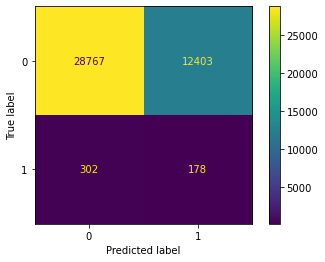

In [623]:
test_models_scores(eclf1, X_smt, y_smt, X_test, y_test)

****************************************************************
Fitting Model: VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rus', RUSBoostClassifier()),
                             ('ada', AdaBoostClassifier()),
                             ('blrf', BalancedRandomForestClassifier())],
                 weights=[1, 2, 1, 2])
Predicting values
****************************************************************
Computing confusion matrix
[[28764 12406]
 [  302   178]]
****************************************************************
accuracy_score: 69.48859543817527%
f1_score: 2.7250459277403554%
recall_score: 37.083333333333336%
precision_score: 1.4144945963127782%
****************************************************************


array(['No', 'Yes', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

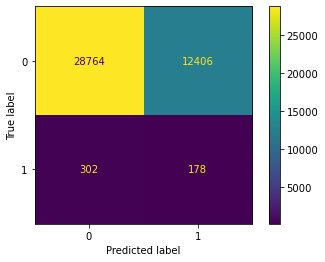

In [624]:
test_models_scores(eclf1, X_smt_scaled, y_smt, X_test_scaled, y_test)

### Manual Undersample dataset

****************************************************************
Fitting Model: VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rus', RUSBoostClassifier()),
                             ('ada', AdaBoostClassifier()),
                             ('blrf', BalancedRandomForestClassifier())],
                 weights=[1, 2, 1, 2])
Predicting values
****************************************************************
Computing confusion matrix
[[22271 18899]
 [  186   294]]
****************************************************************
accuracy_score: 54.17767106842737%
f1_score: 2.9888679916637013%
recall_score: 61.25000000000001%
precision_score: 1.531808471838691%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

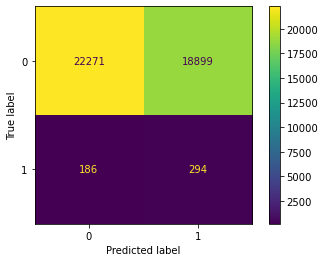

In [684]:
test_models_scores(eclf1, X_train_undersample, y_train_undersample, X_test, y_test)

****************************************************************
Fitting Model: VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rus', RUSBoostClassifier()),
                             ('ada', AdaBoostClassifier()),
                             ('blrf', BalancedRandomForestClassifier())],
                 weights=[1, 2, 1, 2])
Predicting values
****************************************************************
Computing confusion matrix
[[22249 18921]
 [  187   293]]
****************************************************************
accuracy_score: 54.122448979591844%
f1_score: 2.9755255407738397%
recall_score: 61.04166666666667%
precision_score: 1.5249297387321745%
****************************************************************


array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

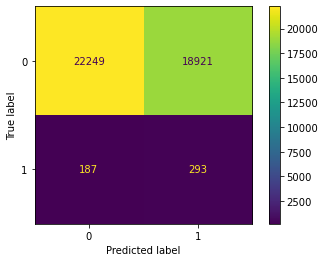

In [685]:
test_models_scores(eclf1, X_train_undersample_scaled, y_train_undersample, X_test_scaled, y_test)

## Pipeline Build

### THIS TAKES CONSIDERABLE TIME

In [271]:
pipeline = Pipeline([
    ('clf_r', RandomForestClassifier())
])

    
parameters = [{
    'clf_r': [RandomForestClassifier()],
    'clf_r__n_estimators': [100, 500, 1000],
    'clf_r__max_features': ['auto','log2'],
    'clf_r__class_weight': ['balanced', 'balanced_subsample']
    },
    {
        'clf_r': [BalancedRandomForestClassifier()],
        'clf_r__n_estimators': [100, 500, 1000],
        'clf_r__sampling_strategy': ['auto', 'all'],
        'clf_r__class_weight': ['balanced', 'balanced_subsample']
    }
        ]
    
model = GridSearchCV(pipeline, param_grid=parameters, verbose=3, cv=3)

In [272]:
pipeline = Pipeline([
    ('clf_r', BalancedRandomForestClassifier())
])

    
parameters = {
        'clf_r__sampling_strategy': ['auto', 'all'],
        'clf_r__n_estimators': [100, 500, 1000],
        'clf_r__class_weight': ['balanced', 'balanced_subsample']
    }
        
    
model2 = GridSearchCV(pipeline, param_grid=parameters, verbose=3, cv=8)

In [273]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100, score=0.972, total=   7.6s
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100, score=0.991, total=   7.8s
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.3s remaining:    0.0s


[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100, score=0.991, total=   8.9s
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500 
[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500, score=0.972, total=  40.8s
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500 
[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500, score=0.991, total=  44.8s
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500 
[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500, score=0.991, total=  44.2s
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balan

[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__max_features=log2, clf_r__n_estimators=500, score=0.991, total=  45.9s
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__max_features=log2, clf_r__n_estimators=1000 
[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__max_features=log2, clf_r__n_estimators=1000, score=0.972, total= 1.4min
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__max_features=log2, clf_r__n_estimators=1000 
[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__max_features=log2, clf_r__n_estimators=1000, score=0.991, total= 1.6min
[CV] clf_r=RandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__max_features=log2, clf_r__n_estimators=1000 
[CV]  clf_r=RandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__max_features=log2, clf_r__n_estimators=1000, score=0.991, 

[CV]  clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=auto, score=0.971, total=  41.6s
[CV] clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=auto 
[CV]  clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=auto, score=0.989, total=  44.4s
[CV] clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=auto 
[CV]  clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=auto, score=0.990, total=  44.3s
[CV] clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=all 
[CV]  clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balan

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 53.5min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('clf_r', RandomForestClassifier())]),
             param_grid=[{'clf_r': [RandomForestClassifier(class_weight='balanced_subsample',
                                                           n_estimators=1000)],
                          'clf_r__class_weight': ['balanced',
                                                  'balanced_subsample'],
                          'clf_r__max_features': ['auto', 'log2'],
                          'clf_r__n_estimators': [100, 500, 1000]},
                         {'clf_r': [BalancedRandomForestClassifier()],
                          'clf_r__class_weight': ['balanced',
                                                  'balanced_subsample'],
                          'clf_r__n_estimators': [100, 500, 1000],
                          'clf_r__sampling_strategy': ['auto', 'all']}],
             verbose=3)

In [274]:
model2.fit(X_train, y_train)

Fitting 8 folds for each of 12 candidates, totalling 96 fits
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto, score=0.938, total=   9.1s
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto, score=0.990, total=   9.6s
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.6s remaining:    0.0s


[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto, score=0.991, total=   9.5s
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto, score=0.991, total=   9.5s
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto, score=0.990, total=   9.4s
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto, score=0.991, total=   9.5s
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=100, clf_r__sampling_strategy=auto, score=0.992, total=   9.6s
[CV] clf_r__class_weight=balanced, clf_r_

[CV] clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all, score=0.991, total= 1.8min
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all, score=0.991, total= 1.8min
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all, score=0.990, total= 1.8min
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all, score=0.991, total= 1.8min
[CV] clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all 
[CV]  clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__

[CV]  clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=all, score=0.992, total=  59.5s
[CV] clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=all 
[CV]  clf_r__class_weight=balanced_subsample, clf_r__n_estimators=500, clf_r__sampling_strategy=all, score=0.990, total=  59.3s
[CV] clf_r__class_weight=balanced_subsample, clf_r__n_estimators=1000, clf_r__sampling_strategy=auto 
[CV]  clf_r__class_weight=balanced_subsample, clf_r__n_estimators=1000, clf_r__sampling_strategy=auto, score=0.939, total= 1.8min
[CV] clf_r__class_weight=balanced_subsample, clf_r__n_estimators=1000, clf_r__sampling_strategy=auto 
[CV]  clf_r__class_weight=balanced_subsample, clf_r__n_estimators=1000, clf_r__sampling_strategy=auto, score=0.991, total= 1.9min
[CV] clf_r__class_weight=balanced_subsample, clf_r__n_estimators=1000, clf_r__sampling_strategy=auto 
[CV]  clf_r__class_weight=balanced_subsample, clf_r__n_estimators=1000, clf_r_

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 94.8min finished


GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('clf_r',
                                        BalancedRandomForestClassifier())]),
             param_grid={'clf_r__class_weight': ['balanced',
                                                 'balanced_subsample'],
                         'clf_r__n_estimators': [100, 500, 1000],
                         'clf_r__sampling_strategy': ['auto', 'all']},
             verbose=3)

In [347]:
model_smt = model.fit(X_smt, y_smt)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100, score=0.987, total=  10.0s
[CV] clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV]  clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100, score=0.993, total=  10.4s
[CV] clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s


[CV]  clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=100, score=0.990, total=  10.5s
[CV] clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500 
[CV]  clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500, score=0.986, total=  52.5s
[CV] clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500 
[CV]  clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced, clf_r__max_features=auto, clf_r__n_estimators=500, score=0.993, total=  54.5s
[CV] clf_r=RandomForestClassifier(class_weight='balanced_subsample

[CV]  clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced_subsample, clf_r__max_features=auto, clf_r__n_estimators=1000, score=0.986, total= 2.2min
[CV] clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced_subsample, clf_r__max_features=auto, clf_r__n_estimators=1000 
[CV]  clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced_subsample, clf_r__max_features=auto, clf_r__n_estimators=1000, score=0.993, total= 2.3min
[CV] clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced_subsample, clf_r__max_features=auto, clf_r__n_estimators=1000 
[CV]  clf_r=RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000), clf_r__class_weight=balanced_subsample, clf_r__max_features=auto, clf_r__n_estimators=1000, score=0.990, total= 2.3min
[CV] clf_r=

[CV]  clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=auto, score=0.993, total= 2.3min
[CV] clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=auto 
[CV]  clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=auto, score=0.990, total= 2.4min
[CV] clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all 
[CV]  clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all, score=0.986, total= 2.8min
[CV] clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=all 
[CV]  clf_r=BalancedRandomForestClassifier(), clf_r__class_weight=balanced, clf_r__n_estimators=1000, clf_r__sampling_strategy=

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 90.1min finished


In [275]:
model1 = model.best_estimator_
model1

Pipeline(steps=[('clf_r',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=1000))])

In [348]:
model_smt.best_estimator_

Pipeline(steps=[('clf_r', RandomForestClassifier(class_weight='balanced'))])

In [276]:
brfc_model = model2.best_estimator_
brfc_model

Pipeline(steps=[('clf_r',
                 BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                n_estimators=1000,
                                                sampling_strategy='all'))])

### Pipeline Testing

In [277]:
model1_pred = model1.predict(X_test)

In [278]:
promotion_yes_no = []
for value in model1_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

In [279]:
print(accuracy_score(y_test, model1_pred))
print(f1_score(y_test, model1_pred))
print(recall_score(y_test, model1_pred))

0.9793517406962785
0.020501138952164006
0.01875


In [292]:
confusion_matrix(y_test, model1_pred)

array([[40781,   389],
       [  471,     9]], dtype=int64)

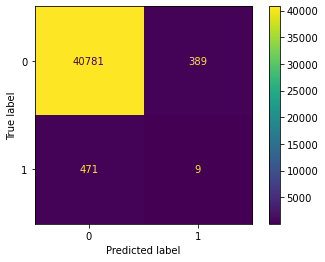

In [296]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model1, X_test, y_test)

In [280]:
brfc_model_pred = brfc_model.predict(X_test)

In [281]:
promotion_yes_no = []
for value in brfc_model_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

In [282]:
print(accuracy_score(y_test, brfc_model_pred))
print(f1_score(y_test, brfc_model_pred))
print(recall_score(y_test, brfc_model_pred))

0.9754861944777912
0.022966507177033493
0.025


In [293]:
confusion_matrix(y_test, brfc_model_pred)

array([[40617,   553],
       [  468,    12]], dtype=int64)

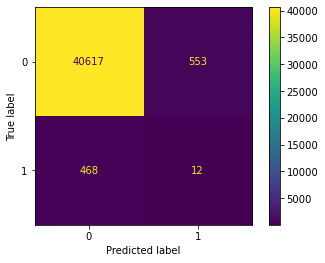

In [294]:
plot_confusion_matrix(brfc_model, X_test, y_test)

In [349]:
model_smt_pred = model_smt.predict(X_test)

In [350]:
promotion_yes_no = []
for value in model_smt_pred:
    if value == 0:
        promotion_yes_no.append("No")
    if value == 1:
        promotion_yes_no.append("Yes")
        
promotion = np.asarray(promotion_yes_no)
    
promotion

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype='<U3')

In [351]:
print(accuracy_score(y_test, model_smt_pred))
print(f1_score(y_test, model_smt_pred))
print(recall_score(y_test, model_smt_pred))

0.9786794717887155
0.01986754966887417
0.01875


In [352]:
confusion_matrix(y_test, model_smt_pred)

array([[40753,   417],
       [  471,     9]], dtype=int64)

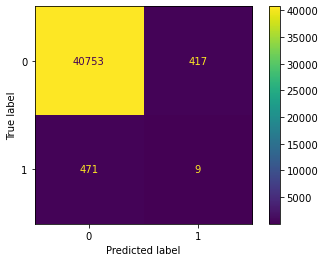

In [353]:

plot_confusion_matrix(model_smt, X_test, y_test)

## Test 2

### RUSBoostClassifier

In [382]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    ''' 
    
    """dummy_df = pd.get_dummies(data=df, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
    X = dummy_df.iloc[:,5:]
    y = dummy_df['purchase']
    svms = SVMSMOTE(random_state=42)
    X, y = svms.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)"""
    
    # rus
    
    rus_y_pred = rus.predict(df)
    my_map = {0: "No", 1: "Yes"}
    promotion = np.vectorize(my_map.get)(rus_y_pred)
    
    return promotion

In [383]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0192.

Your nir with this strategy is 55.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019224829224829224, 55.0)

### ADABoostClassifier

In [388]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    ''' 
    
    """dummy_df = pd.get_dummies(data=df, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
    X = dummy_df.iloc[:,5:]
    y = dummy_df['purchase']
    svms = SVMSMOTE(random_state=42)
    X, y = svms.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)"""
    
    # rfc = RandomForestClassifier(min_samples_split=3)
    
    ada_y_pred = ada_smt.predict(df)
    my_map = {0: "No", 1: "Yes"}
    promotion = np.vectorize(my_map.get)(ada_y_pred)
    
    return promotion

In [389]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0192.

Your nir with this strategy is 55.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019224829224829224, 55.0)

### Gradient Boosting Classifier

In [560]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    gbc_y_pred = gbc.predict(df)
    my_map = {0: "No", 1: "Yes"}
    promotion = np.vectorize(my_map.get)(gbc_y_pred)
    
    return promotion

In [561]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0102.

Your nir with this strategy is -695.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.010179472360449516, -695.5999999999999)

In [356]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    ''' 
    
    """dummy_df = pd.get_dummies(data=df, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
    X = dummy_df.iloc[:,5:]
    y = dummy_df['purchase']
    svms = SVMSMOTE(random_state=42)
    X, y = svms.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)"""
    
    # rfc = RandomForestClassifier(min_samples_split=3)
    
    model_smt_pred = model_smt.predict(df)
    my_map = {0: "No", 1: "Yes"}
    promotion = np.vectorize(my_map.get)(model_smt_pred)
    
    return promotion

In [357]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0254.

Your nir with this strategy is 24.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.025397652345212705, 24.15)

In [687]:
eclf1 = eclf1.fit(X_train_undersample, y_train_undersample)

In [688]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    ''' 
    
    """dummy_df = pd.get_dummies(data=df, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
    X = dummy_df.iloc[:,5:]
    y = dummy_df['purchase']
    svms = SVMSMOTE(random_state=42)
    X, y = svms.fit_resample(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)"""
    
    # rfc = RandomForestClassifier(min_samples_split=3)
    
    eclf1_pred = eclf1.predict(df)
    my_map = {0: "No", 1: "Yes"}
    promotion = np.vectorize(my_map.get)(eclf1_pred)
    
    return promotion

In [689]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0177.

Your nir with this strategy is 249.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.017700903621992968, 249.60000000000014)

---

## Further Exploration

In [690]:
import pickle
filename1 = 'eclf1.pkl'
pickle.dump(eclf1, open(filename1, 'wb'))

In [300]:
filename2 ='brfc_model.pkl'
pickle.dump(brfc_model, open(filename2, 'wb'))

In [302]:
loaded_model = pickle.load(open(filename1, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9793517406962785


In [288]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [289]:
from sklearn.model_selection import learning_curve
from matplotlib.ticker import FuncFormatter

C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py", line 548, in fit
    for i, (s, t) in enumerate(zip(samplers, trees))
  File "C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\ejmason\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\ejmason\AppD

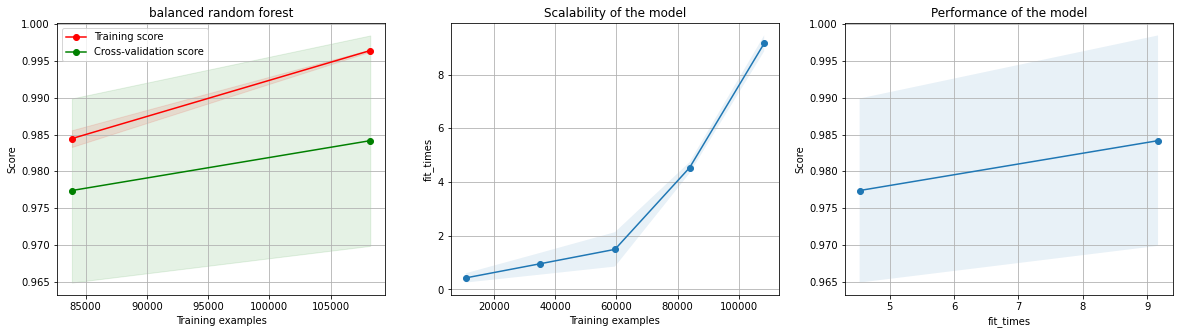

In [290]:
plot_learning_curve(blrf, 'balanced random forest', X_train, y_train, cv=6);

pandas.core.series.Series